#Import Statements


In [0]:
import warnings
warnings.filterwarnings("ignore")
!pip install ftfy #fixes text for you
import ftfy
import matplotlib.pyplot as plt
import matplotlib
import nltk
import numpy as np
import pandas as pd
import re #regular expression operations

from math import exp
from numpy import sign
from sklearn.metrics import *
from gensim.models import KeyedVectors #To extract pretrained vectors for the Word2Vec model 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt') #This tokenizer divides a text into a list of sentences
from nltk import PorterStemmer

from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from wordcloud import WordCloud
import pickle

!pip install scikit-plot
import scikitplot as skplt





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:

# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

#Load Data


In [0]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
sentiment140_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
pos = sentiment140_df[sentiment140_df['0']==4]
pos = pos.head(5)
sad = sentiment140_df.head(5)
pos_sad = pos.append(sad)
pos_sad

In [0]:
sentiment140_df.name.unique()

In [0]:
DEPRESSIVE_FILE = "/content/Sentiment Analysis Dataset 2.csv"
RANDOM_FILE = "/content/Sentiment Analysis Dataset 2.csv"
EMBEDDING_FILE ="/content/GoogleNews-vectors-negative300.bin.gz"

In [0]:
depressive_df = pd.read_csv(DEPRESSIVE_FILE, sep = '|', header = None, usecols = range(0,1), nrows = DEPRES_NROWS)
depressive_df.head()


,0
0,tweet
1,Gary Gulman's The Great Depresh is well worth ...
2,It can take antidepressants up to six weeks to...
3,"This Sunday, Cumberland + 515 will be together..."
4,Depression was ruining a social media star's l...


In [0]:
random_df = pd.read_csv(RANDOM_FILE, encoding = "ISO-8859-1", usecols = range(0,4), nrows = 10000)
random_df.head()


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


#Data Preprocessing



##1.   Get rid of stuff like "what's" and making it "what is'



In [0]:
# Expand Contraction
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}
ecList_compiled = re.compile('|'.join(appos.keys()))

def expC(text):
  
  for word, initial in appos.items():
      text = text.replace(word, initial)
  return text


def expandContractions(text, ecList_compiled=ecList_compiled):
    def replace(match):
        return appos[match.group(0)]
    return ecList_compiled.sub(replace, text)

In [0]:
text = "you've"
print(expC(text))

you have





###*   Remove links, images, hashtags, @, emojis, punctuations

###*   Remove stop words

###*   Stemming











In [0]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            tweet = re.sub(r'^httpss?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
            tweet = re.sub(r"http\S+", "", tweet)
            # tweet = tweet.replace("https", "")
            # tweet = tweet.replace("http", "")
            # tweet = tweet.replace("com", "")
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)
            #remove digits
            tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [0]:
# test_text = [depressive_df[0][5]]
test_text = ["https://stackoverflow.com/questions/33094164/regular-expre, abc"]

In [0]:
test_text 


['https://stackoverflow.com/questions/33094164/regular-expre, abc']

In [0]:

depressive_tweets_arr = [x for x in depressive_df[0]]
random_tweets_arr = [x for x in random_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

##Data Visualization

In [0]:
depressive_df['tweet_len'] = X_[0].astype(str).apply(len)
depressive_df['word_count'] = depressive_df[0].apply(lambda x: len(str(x).split()))
depressive_df.head()

random_df['tweet_len'] = random_df['SentimentText'].astype(str).apply(len)
random_df['word_count'] = random_df['SentimentText'].apply(lambda x: len(str(x).split()))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

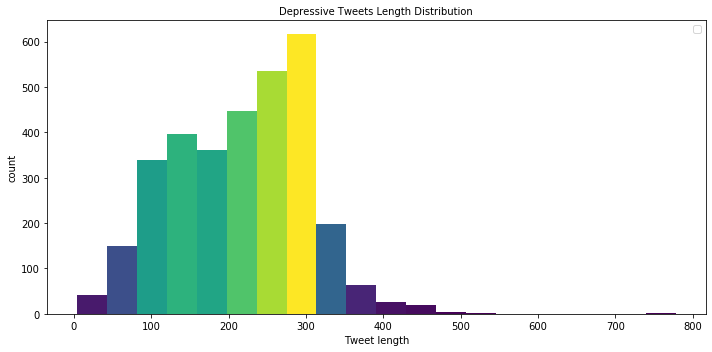

In [0]:
fig, axs = plt.subplots(tight_layout=True)
axs.set_xlabel('Tweet length', fontsize=10)
axs.set_ylabel('count', fontsize=10)
axs.set_title('Depressive Tweets Length Distribution', fontsize=10)
fig.set_figheight(5)
fig.set_figwidth(10)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(depressive_df['tweet_len'], bins=20)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)



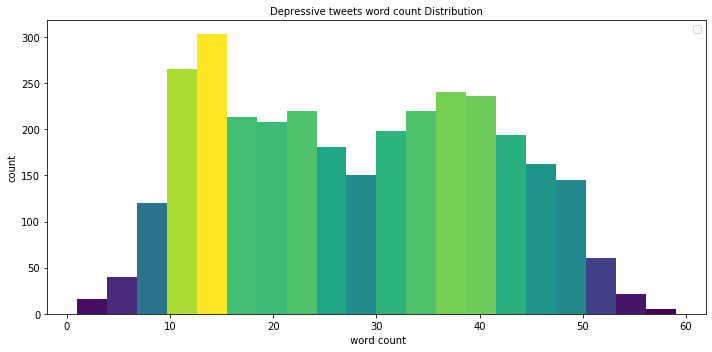

In [0]:
fig, axs = plt.subplots(tight_layout=True)
axs.set_xlabel(' word count', fontsize=10)
axs.set_ylabel('count', fontsize=10)
axs.set_title('Depressive tweets word count Distribution', fontsize=10)
fig.set_figheight(5)
fig.set_figwidth(10)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(depressive_df['word_count'], bins=20)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)


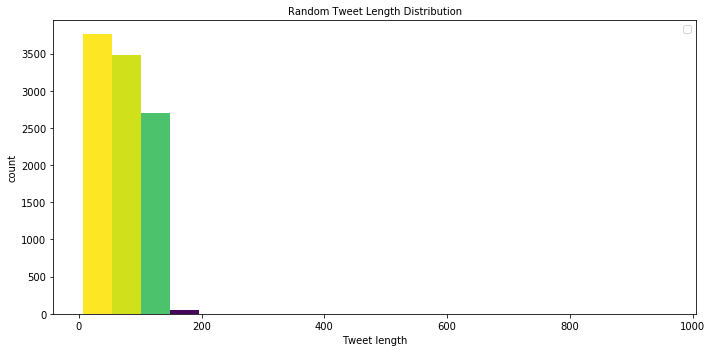

In [0]:
random_df['tweet_len'] = random_df['SentimentText'].astype(str).apply(len)
random_df['word_count'] = random_df['SentimentText'].apply(lambda x: len(str(x).split()))

fig, axs = plt.subplots(tight_layout=True)
axs.set_xlabel('Tweet length', fontsize=10)
axs.set_ylabel('count', fontsize=10)
axs.set_title('Random Tweet Length Distribution', fontsize=10)
fig.set_figheight(5)
fig.set_figwidth(10)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(random_df['tweet_len'], bins=20)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)



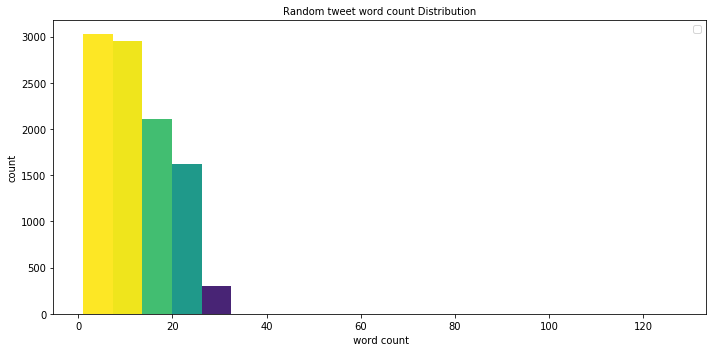

In [0]:
fig, axs = plt.subplots(tight_layout=True)
axs.set_xlabel(' word count', fontsize=10)
axs.set_ylabel('count', fontsize=10)
axs.set_title('Random tweet word count Distribution', fontsize=10)
fig.set_figheight(5)
fig.set_figwidth(10)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(random_df['word_count'], bins=20)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

#Positive Data WordCloud

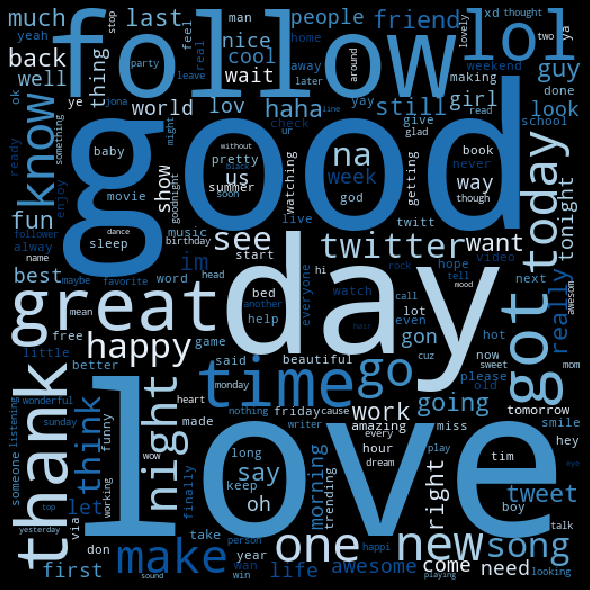

In [0]:
ran =random_df[random_df['Sentiment']==1]

ran_arr = [x for x in ran['SentimentText']]

X_ran = clean_tweets(ran_arr)
random_wc_data = ' '.join(X_ran)
wordcloud = WordCloud().generate(random_wc_data)

positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(random_wc_data)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [0]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

## Top 10 Words In Potitive Tweets

<BarContainer object of 10 artists>

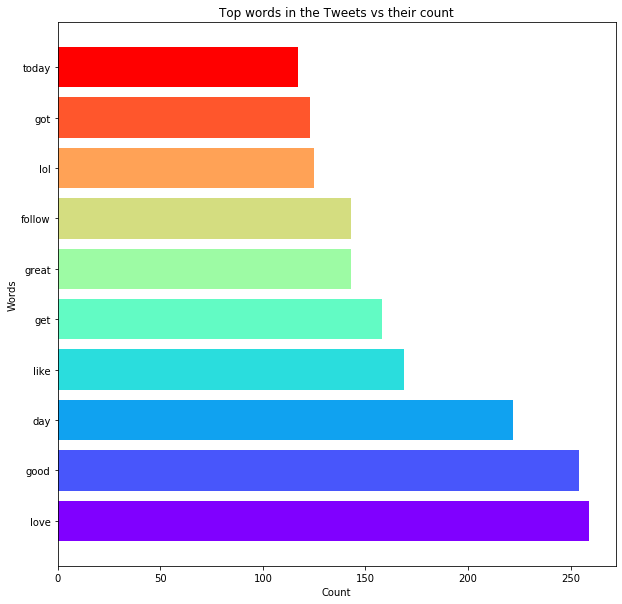

In [0]:
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))
filtered_words = [word for word in random_wc_data.split() if word not in stoplist]

filtered_words = [x for x in filtered_words if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 10

plt.title('Top words in the Tweets vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

#Depressive Data WordCloud

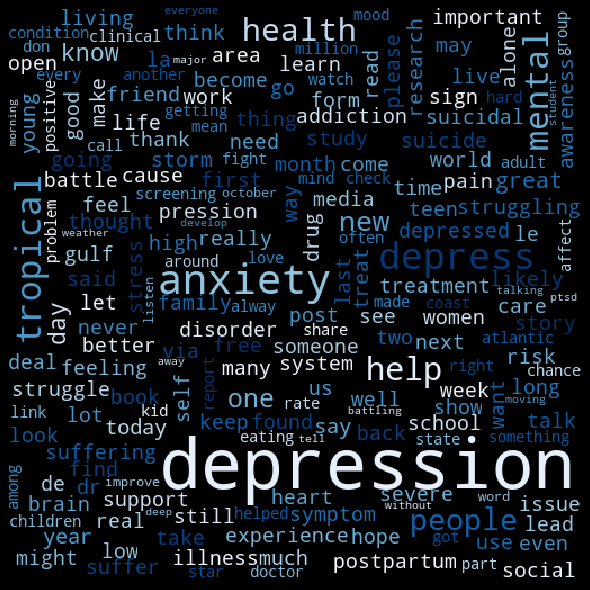

In [0]:

depressive_wc_data = ' '.join(X_d)

wordcloud = WordCloud().generate(depressive_wc_data)

depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_wc_data)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Top 10 Words in Depressive Tweets

<BarContainer object of 10 artists>

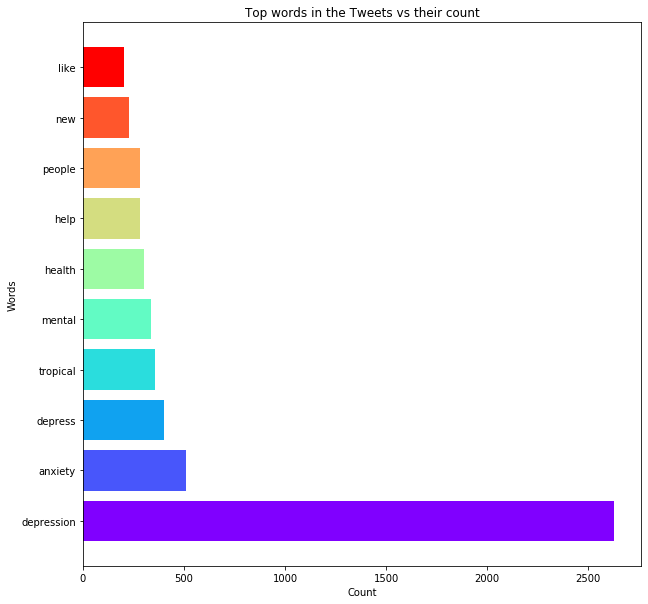

In [0]:
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))
filtered_words = [word for word in depressive_wc_data.split() if word not in stoplist]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 10

plt.title('Top words in the Tweets vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [0]:
depressive_tweets_arr[1]

"Gary Gulman's The Great Depresh is well worth watching if you or anyone you know has depression or anxiety. It's also nice to watch a high-profile new stand-up special that doesn't spend its first half on how you can't make jokes anymore."

In [0]:
X_t = clean_tweets(test_text)

##Cleaning Print

In [0]:
text = 'Battling the symptoms of #depression, is no doubt difficult, but itâ€™s important that people understand theyâ€™re not alone. Find out how you can help at  http://adaa.orgÂ . #ArmyMedicine pic.twitter.com/5FOXA92Uvk'
print(text,"\n")
print("Remove links:")
d = re.sub(r'http\S+', '', text)
print(d,'\n')
print("Remove images, hashtags, @,v  emojis, punctuations:")
d = re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", d)
print(d,'\n')
print("Remove weirdly encoded texts:")
d=ftfy.fix_text(d)
print(d,'\n')
print("Expand Contraction:")
d = expC(d)
print(d,'\n')
print("Remove punctuations:")

d = re.sub("([^0-9A-Za-z \t])"," ",d)
print(d,'\n') 

print("stopwords:")
s = set(stopwords.words('english'))
print(s)

wt = nltk.word_tokenize(d)
print(wt)

print("filtered_sentence")
filtered_sentence = [w for w in wt if not w in s]
tweet = ' '.join(filtered_sentence)
  
print(tweet)

f=[]
for w in wt:
  if w not in s:
    w = PorterStemmer().stem(w)
    f.append(w)

print(f)

tweet= PorterStemmer().stem("d")
print(tweet)




Battling the symptoms of #depression, is no doubt difficult, but itâ€™s important that people understand theyâ€™re not alone. Find out how you can help at  http://adaa.orgÂ . #ArmyMedicine pic.twitter.com/5FOXA92Uvk 

Remove links:
Battling the symptoms of #depression, is no doubt difficult, but itâ€™s important that people understand theyâ€™re not alone. Find out how you can help at   . #ArmyMedicine pic.twitter.com/5FOXA92Uvk 

Remove images, hashtags, @,v  emojis, punctuations:
Battling the symptoms of  , is no doubt difficult, but itâ€™s important that people understand theyâ€™re not alone. Find out how you can help at   .     

Remove weirdly encoded texts:
Battling the symptoms of  , is no doubt difficult, but it's important that people understand they're not alone. Find out how you can help at   .     

Expand Contraction:
Battling the symptoms of  , is no doubt difficult, but it is important that people understand they are not alone. Find out how you can help at   .     

Remov

In [0]:

def clean_text(text):
   
    cleaned_text = []
    
    for line in text:
      
      line = str(line)
      if len(line) > 10:
        #Remove links:
        line = re.sub(r'http\S+', '', line)
        
        #Remove images, hashtags, @,v  emojis, punctuations:        
        line = re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", line)
        
        #Remove weirdly encoded texts:
        line=ftfy.fix_text(line)
        
        #Expand Contraction:
        line = expC(line)
        
        #Remove punctuations:
        line = re.sub("([^0-9A-Za-z \t])"," ",line)
        
        #Remove Stopwords
        
        #1. stopwords:        
        s = set(stopwords.words('english'))
        
        #2. tokenization
        wt = nltk.word_tokenize(line)
        
        #3. remove stopwords using step 1 and 2
        
        filtered_line =[]
        for w in wt:
          if w not in s:
            #stemming filtered words
            
            w = PorterStemmer().stem(w)
            filtered_line.append(w)
            
        text = ' '.join(filtered_line)  
        
        cleaned_text.append(text)
        
        
    return cleaned_text

 

#Tokenization
1. fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

2. texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

In [0]:
#Using a Tokenizer to assign indices and filtering out unfrequent words. 
#Tokenizer creates a map of every unique word and an assigned index to it. 
#The parameter called num_words indicates that we only care about the top 20000 most frequent words.


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [0]:
tokenizer.word_index

In [0]:
tokenizer.fit_on_texts(X_t)

In [0]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)
# sequences_t = tokenizer.texts_to_sequences(X_t)

In [0]:
sequences_d[1]

[8,
 63,
 2212,
 1137,
 426,
 1332,
 2475,
 9,
 732,
 193,
 5975,
 3734,
 660,
 19,
 2476,
 222,
 2,
 159,
 427,
 56]

In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 19702 unique tokens


In [0]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
# data_t = pad_sequences(sequences_t, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)
# print('Shape of data_r tensor:', data_t.shape)

Shape of data_d tensor: (3197, 140)
Shape of data_r tensor: (9914, 140)


In [0]:
data_t

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 77]], dtype=int32)

#Embdding Matrix

Using a Keyed Vectors file, we can get the embedding of any word by calling .word_vec(word) and we can get all the words in the model's vocabulary through .vocab.

In [0]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [0]:
word2vec

In [0]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [0]:
RANDOM_NROWS

12000

#Train/Val/Test Split

In [0]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
print(labels_test)
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))

# perm_t = np.random.permutation(1)


data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
# labels_t = labels_t[perm_t]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

[1 1 1 ... 0 0 0]


In [0]:

labels_t = np.array([1])
labels_t
# labels_train



array([1])

# Model Building 

The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with it's embeddings, then run the new embedding vector through a convolutional layer. CNNs are excellent at learning spatial structure from data, the convolutional layer takes advantage of that and learn some structure from the sequential data then pass into a standard LSTM layer. Last but not least, the output of the LSTM layer is fed into a standard Dense model for prediction.

In [0]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Train on 7866 samples, validate on 2623 samples
Epoch 1/10
7866/7866 [==============================] - 71s 9ms/step - loss: 0.1097 - acc: 0.9676 - val_loss: 0.0256 - val_acc: 0.9943
Epoch 2/10
7866/7866 [==============================] - 72s 9ms/step - loss: 0.0290 - acc: 0.9929 - val_loss: 0.0276 - val_acc: 0.9928
Epoch 3/10
7866/7866 [==============================] - 73s 9ms/step - loss: 0.0190 - acc: 0.9957 - val_loss: 0.0293 - val_acc: 0.9924
Epoch 4/10
7866/7866 [==============================] - 70s 9ms/step - loss: 0.0187 - acc: 0.9948 - val_loss: 0.0282 - val_acc: 0.9924


In [0]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.20%


In [0]:

print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1983
           1       0.99      0.98      0.98       639

    accuracy                           0.99      2622
   macro avg       0.99      0.99      0.99      2622
weighted avg       0.99      0.99      0.99      2622



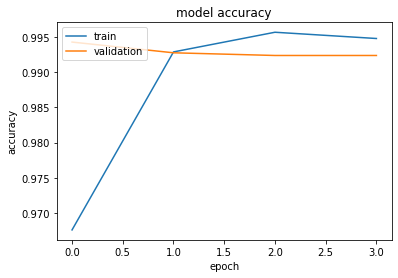

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

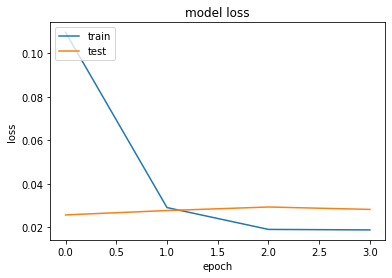

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_target=labels_test, 
                      y_predicted=labels_pred, 
                      binary=True, 
                      positive_label=1)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [0]:

skplt.metrics.plot_confusion_matrix(labels_test, labels_pred, normalize=True,figsize=(16,6), cmap='RdPu')


##Model Export

In [0]:
with open(/text_classifier, 'wb') as picklefile:
    pickle.dump(model,picklefile)

##Model Import

In [0]:
with open('/content/text_classifier', 'rb') as training_model:
    model2 = pickle.load(training_model)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




#Model Prediction

In [0]:
labels_pred2 = model2.predict(data_test)
labels_pred2 = np.round(labels_pred2.flatten())
accuracy = accuracy_score(labels_test, labels_pred2)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 88.29%


## Precision - Recall

In [0]:
print(classification_report(labels_test, labels_pred2))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1983
           1       0.74      0.80      0.77       639

    accuracy                           0.88      2622
   macro avg       0.84      0.86      0.85      2622
weighted avg       0.89      0.88      0.88      2622



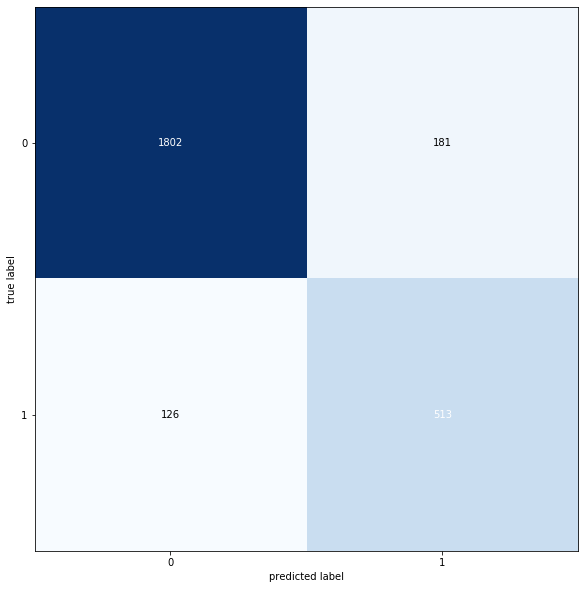

In [0]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(labels_test, 
                      labels_pred2)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

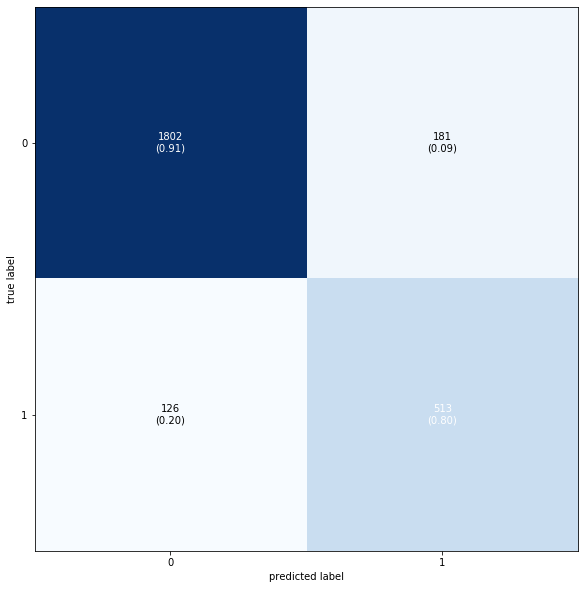

In [0]:
cm = confusion_matrix(labels_test, 
                      labels_pred2)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm,show_normed=True)
plt.show()

Epoch 1/1
786/786 [==============================] - 6s 8ms/step - loss: 0.4008 - acc: 0.8919
Epoch 1/1
1573/1573 [==============================] - 10s 6ms/step - loss: 0.1675 - acc: 0.9396
Epoch 1/1
2359/2359 [==============================] - 15s 6ms/step - loss: 0.1066 - acc: 0.9716
Epoch 1/1
3146/3146 [==============================] - 20s 6ms/step - loss: 0.0830 - acc: 0.9755
Epoch 1/1
3933/3933 [==============================] - 26s 7ms/step - loss: 0.0674 - acc: 0.9809
Epoch 1/1
4719/4719 [==============================] - 30s 6ms/step - loss: 0.0601 - acc: 0.9822
Epoch 1/1
5506/5506 [==============================] - 35s 6ms/step - loss: 0.0370 - acc: 0.9895
Epoch 1/1
6292/6292 [==============================] - 40s 6ms/step - loss: 0.0353 - acc: 0.9908
Epoch 1/1
7079/7079 [==============================] - 44s 6ms/step - loss: 0.0347 - acc: 0.9901
Epoch 1/1
7866/7866 [==============================] - 50s 6ms/step - loss: 0.0341 - acc: 0.9916


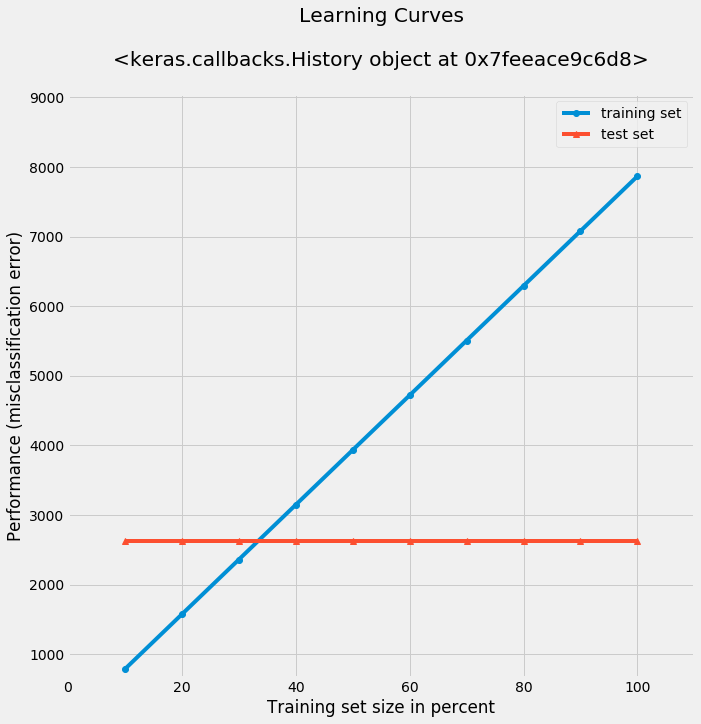

In [0]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


plot_learning_curves(data_train, labels_train, data_val,labels_val, model2)
plt.show()

Epoch 1/1
786/786 [==============================] - 5s 6ms/step - loss: 0.0134 - acc: 0.9975
Epoch 1/1
1573/1573 [==============================] - 10s 6ms/step - loss: 0.0103 - acc: 0.9981
Epoch 1/1
2359/2359 [==============================] - 16s 7ms/step - loss: 0.0063 - acc: 0.9987
Epoch 1/1
3146/3146 [==============================] - 20s 6ms/step - loss: 0.0143 - acc: 0.9959
Epoch 1/1
3933/3933 [==============================] - 25s 6ms/step - loss: 0.0119 - acc: 0.9959
Epoch 1/1
4719/4719 [==============================] - 30s 6ms/step - loss: 0.0175 - acc: 0.9951
Epoch 1/1
5506/5506 [==============================] - 35s 6ms/step - loss: 0.0132 - acc: 0.9964
Epoch 1/1
6292/6292 [==============================] - 39s 6ms/step - loss: 0.0120 - acc: 0.9978
Epoch 1/1
7079/7079 [==============================] - 45s 6ms/step - loss: 0.0194 - acc: 0.9949
Epoch 1/1
7866/7866 [==============================] - 51s 6ms/step - loss: 0.0240 - acc: 0.9943


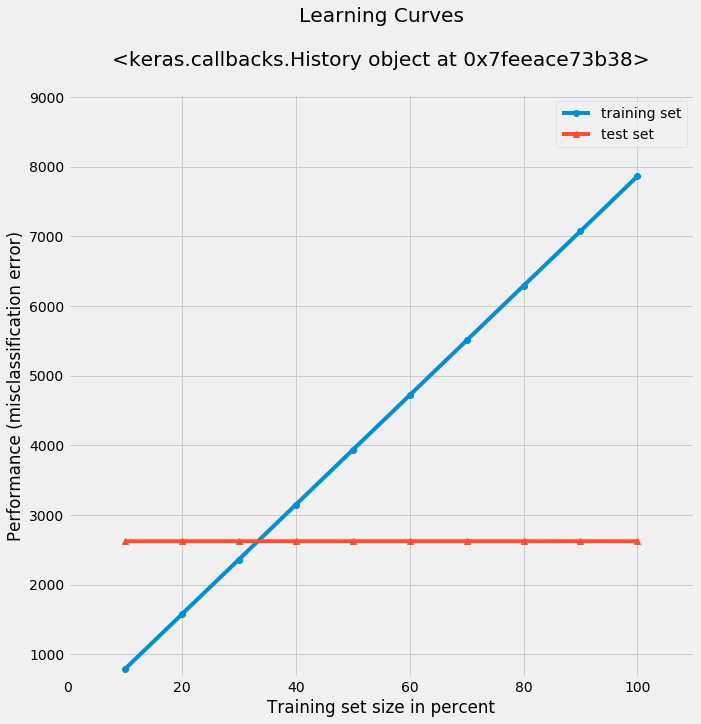

In [0]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


plot_learning_curves(data_train, labels_train, data_test,labels_test, model2)
plt.show()